<a href="https://colab.research.google.com/github/ymuto0302/base2_2020/blob/master/GIS5_WDI_education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地理情報の活用：SDGs と地理情報
SDGs では貧困，教育，平等性，気候変動等，様々な問題が取り上げられている。

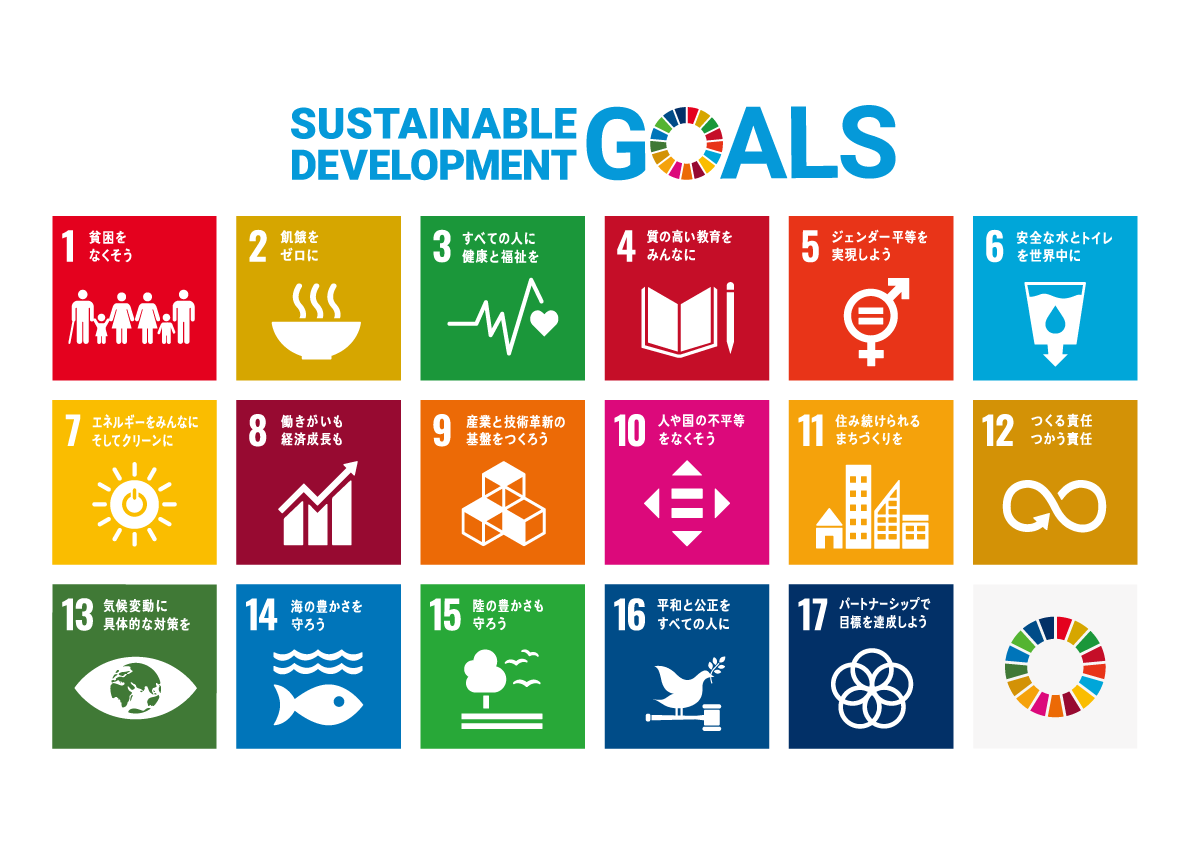

### 前回の授業
"World Development Indicators" データセットを利用し，アフリカ諸国における access to electorcity / improved water 等を地理データ上に展開した。

### 今回の授業
前回に引き続き，利用するデータセットは "World Development Indicators" である。
今回は「教育」に焦点を当て，各国の状況を可視化する。

例によって "World Development Indicators" の URL は以下のとおり：

https://datacatalog.worldbank.org/dataset/world-development-indicators

## (ウォーミングアップ) アジアにおける "access to electrocity"
前週に取り上げた "access to electrocity" を **アジア** で見てみよう。

### World Development Indicators のデータを全て読み込む

In [ ]:
import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

### アジアのみを取り出す
Wikipedia 上の国名コードの一覧 ( https://ja.wikipedia.org/wiki/ISO_3166-1 )から
アジアに分類される国名・国コードを抽出し，ファイル Asia.csv に格納した。

In [ ]:
import pandas as pd

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

In [ ]:
asia.head()

,国・地域名,ISO 3166-1における英語名,numeric,alpha-3,alpha-2,場所,各行政区分
0,ウズベキスタン,Uzbekistan,860,UZB,UZ,中央アジア,ISO 3166-2:UZ
1,カザフスタン,Kazakhstan,398,KAZ,KZ,中央アジア,ISO 3166-2:KZ
2,キルギス,Kyrgyzstan,417,KGZ,KG,中央アジア,ISO 3166-2:KG
3,タジキスタン,Tajikistan,762,TJK,TJ,中央アジア,ISO 3166-2:TJ
4,トルクメニスタン,Turkmenistan,795,TKM,TM,中央アジア,ISO 3166-2:TM


### 可視化
(注意) アジア諸国に絞り込む際のコードが前回と異なる。(pandas オススメの書き方に変更した)

#### (メモ) .loc を利用した値の修正について
データの絞り込みについて，多くのサイトに下記のコードが掲載されているが，pandas は warning を発する。

`data[data['CountryCode'].isin(asia_iso_a3)]`

詳細は下記の Web ページを参照すること：

https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<AxesSubplot:title={'center':'Access to electricity (% of population)'}>

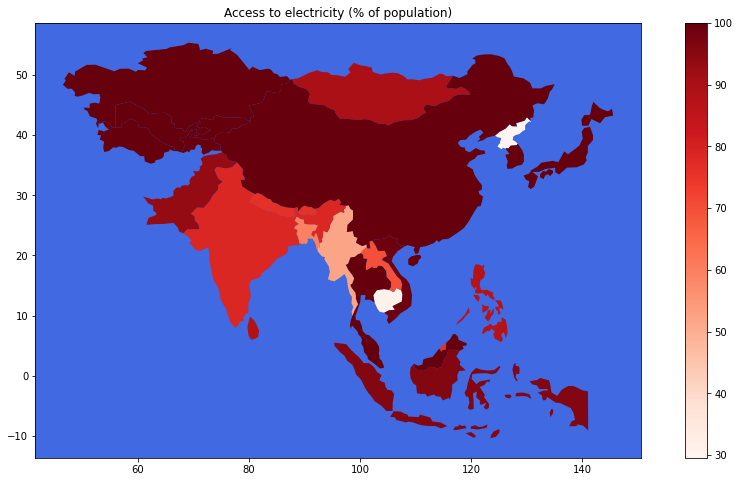

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'EG.ELC.ACCS.ZS']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
# (注意) 前回より，この部分のコードを変更した
asia_data = data.copy() # データのコピー
asia_data = asia_data[data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
asia_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(asia_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_title("Access to electricity (% of population)")
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる


### 考察
北朝鮮(Korea, Dem. Rep.) とカンボジア(Cambodia)の数値が極めて低いようだ。

これらの値を見てみよう。

In [ ]:
asia_data[asia_data['CountryName'].str.contains('Korea')]

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5296926,"Korea, Dem. Rep.",PRK,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,29.56256
5297166,"Korea, Rep.",KOR,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,100.00000


In [ ]:
asia_data[asia_data['CountryName']=='Cambodia']

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5247499,Cambodia,KHM,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,31.1


# ここから本番！

各国の "就学率" および "gender parity index" を取り上げる。

## (テーマ1) 就学率
一般に学校教育は
- primary  education: 初等教育（小学校）
- secondary education: 中等教育（中学校・高等学校）
- tertiary education: 高等教育（大学・大学院）

の３段階に分けられる。もちろん国によって初等教育や中等教育の年限は多少，異なるが，
本授業では細かい点に留意しない。

### 初等教育における就学率
以下ではアジア各国の「初等教育における就学率」を見てみよう。

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = data.copy() # データのコピー
asia_data = asia_data[data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

In [ ]:
asia_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5239018,Bhutan,BTN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,112.331871
5243663,Brunei Darussalam,BRN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,95.458504
5247871,Cambodia,KHM,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,124.175407
5252906,China,CHN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,127.852051
5284691,"Hong Kong SAR, China",HKG,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,101.160431


一般に ""gross enrolment ratio (GER)" は 100% を超える。

分かりやすい説明が unesco.org に掲載されているから，参照してください。

http://uis.unesco.org/en/glossary-term/gross-enrolment-ratio#:~:text=A%20GER%20value%20approaching%20or,indicate%20the%20proportion%20already%20enrolled.

そこで 100% を超えるケースについては，全て 100% とみなして処理を進めていこう。

**(注) gross でなく adjusted net の値も存在するが，国によって集計年度が異なるため，コードがややこしくなる。故に，本授業では（誤差が含まれるものの，傾向を掴むには問題ないとみなし）gross の値を用いる。**

In [ ]:
# 就学率は 100% を超えるものだ，という前提に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

In [ ]:
extracted_data.head()

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5239018,Bhutan,BTN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000
5243663,Brunei Darussalam,BRN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,95.458504
5247871,Cambodia,KHM,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000
5252906,China,CHN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000
5284691,"Hong Kong SAR, China",HKG,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000


可視化する

<AxesSubplot:>

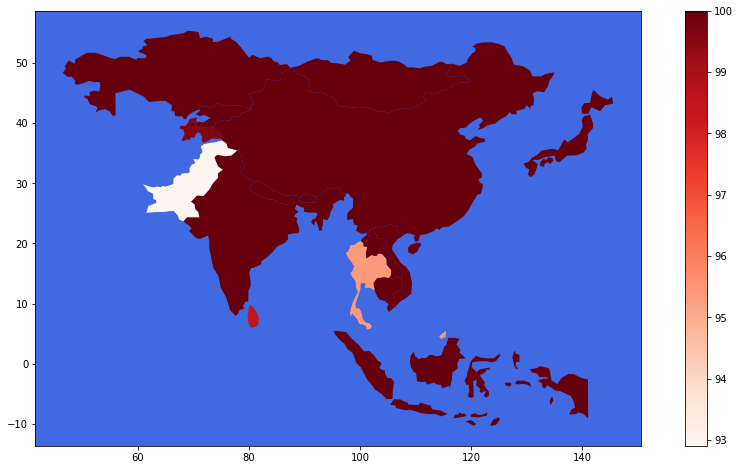

In [ ]:
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### ここまでをまとめたコード

<AxesSubplot:>

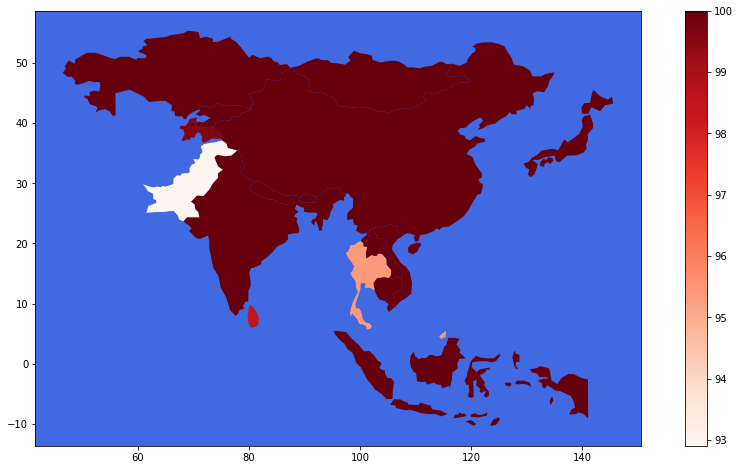

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = data.copy() # データのコピー
asia_data = asia_data[data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### 考察
殆どの国で 100% の就学率を達成している。
パキスタンが最低といっても 93% 近い。ミャンマー，スリランカがやや低めである。

In [ ]:
extracted_data[extracted_data['CountryName']=='Pakistan']

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5329552,Pakistan,PAK,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,92.902702


### 同じ要領で中等教育での就学率(SE.SEC.ENRR: Gross enrolment ratio, secondary, both sexes (%) )を見てみよう

<AxesSubplot:title={'center':'Access to electricity (% of population)'}>

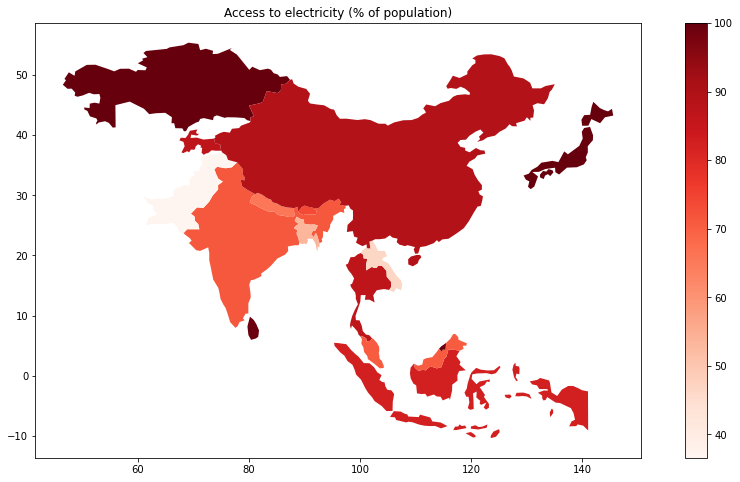

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.SEC.ENRR']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = data.copy() # データのコピー
asia_data = asia_data[data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### 同じ要領で高等教育での就学率(SE.TER.ENRR: Gross enrolment ratio, tertiary, both sexes (%) )を見てみよう

<AxesSubplot:>

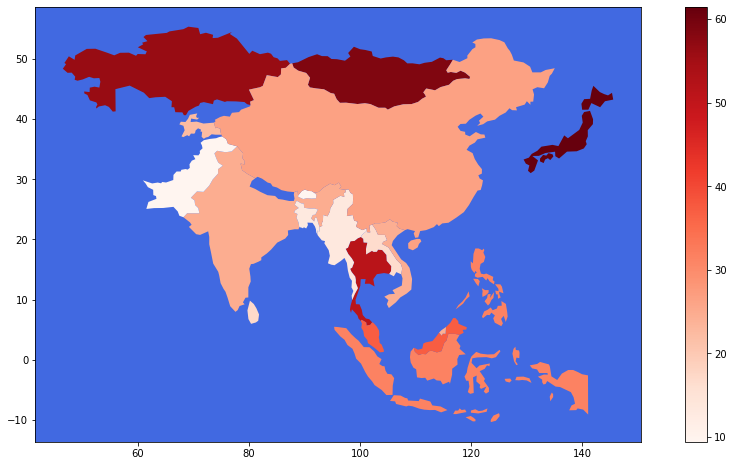

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.TER.ENRR']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = data.copy() # データのコピー
asia_data = asia_data[data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### 初等・中等・高等教育における就学率の比較
上記のコードの一部をまとめ，初等(primary), 中等(secondary)，高等(tertiary)それぞれの就学率を比較する。
ただし，３つの図においてスケールが異なる点に注意が必要である。

<AxesSubplot:title={'center':'tertiary'}>

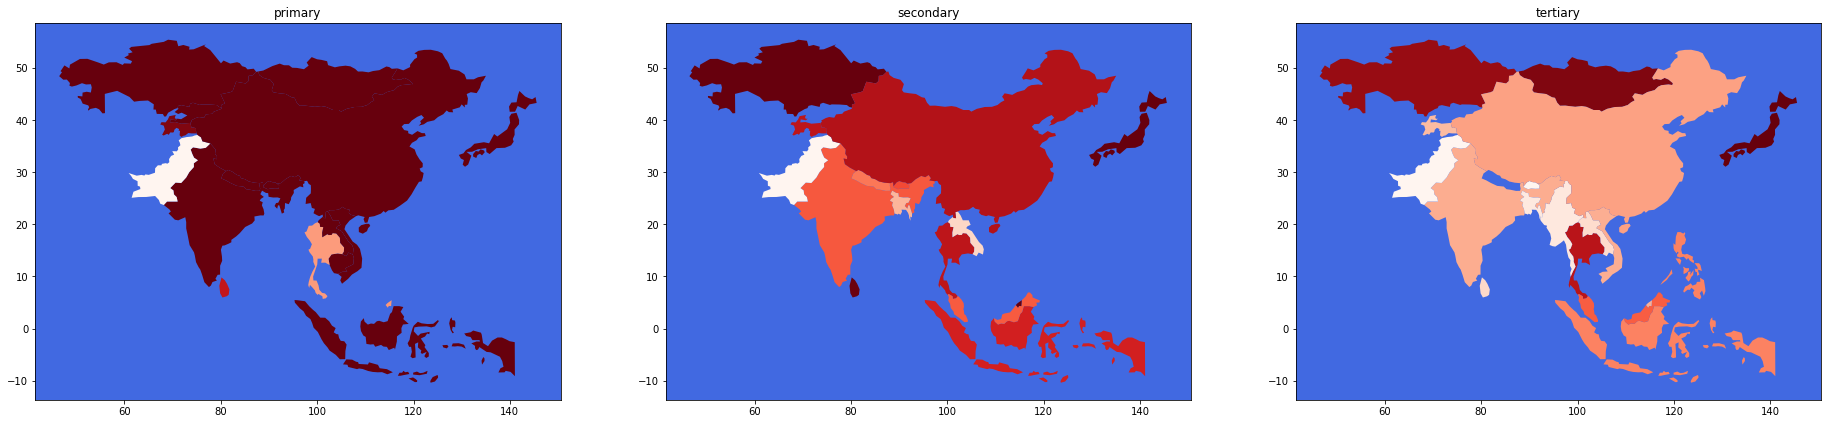

In [ ]:
import pandas as pd

def extract(data, country_iso_a3, year=2012):
    data = data[data['Year'] == year]
    data = data[data['CountryCode'].isin(country_iso_a3)]

    # 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
    extracted_data = data.copy() # データフレームのコピー
    mask = data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
    extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

    # 後のマージのため，列名 CountryCode を iso_a3 へリネーム
    extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

    return extracted_data

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
primary = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']
secondary = indicators[indicators['IndicatorCode'] == 'SE.SEC.ENRR']
tertiary = indicators[indicators['IndicatorCode'] == 'SE.TER.ENRR']

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# 2012年のデータのみに絞り込む
# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
primary = extract(primary, asia_iso_a3, year=2012)
secondary = extract(secondary, asia_iso_a3, year=2012)
tertiary = extract(tertiary, asia_iso_a3, year=2012)

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 国コードをキーとしてマージする
merged_primary = world.merge(primary, how='inner', on='iso_a3', copy=True)
merged_secondary = world.merge(secondary, how='inner', on='iso_a3', copy=True)
merged_tertiary = world.merge(tertiary, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'royalblue' # 背景色の設定 (複数の図に一斉に設定するパターン)

fig, ax = plt.subplots(1, 3, figsize=(32, 16)) # 1行 3列
ax[0].set_title("primary")
ax[1].set_title("secondary")
ax[2].set_title("tertiary")
merged_primary.plot(ax=ax[0], column='Value', cmap='Reds') #, legend=True)
merged_secondary.plot(ax=ax[1], column='Value', cmap='Reds') #, legend=True)
merged_tertiary.plot(ax=ax[2], column='Value', cmap='Reds') #, legend=True)

### 考察
ミャンマーが不思議な傾向を示す。
初等教育では他国に比べて低水準だが，中等教育では中国・インドネシアと同等，
高等教育では中国等を追い越している。

## (テーマ2) gender parity index (GPI)
就学率における gender parity index (GPI) とは，「女子の就学率/男子の就学率」で計算される。
すなわち，GPI の値が1を上回ると女子の方が就学率が高く，
逆に1を下回る場合は男子の方が就学率が高いということを示す。

ジェンダーによる不平等性の解消という観点から 1.0 前後にあることが望ましい指標である。

<AxesSubplot:>

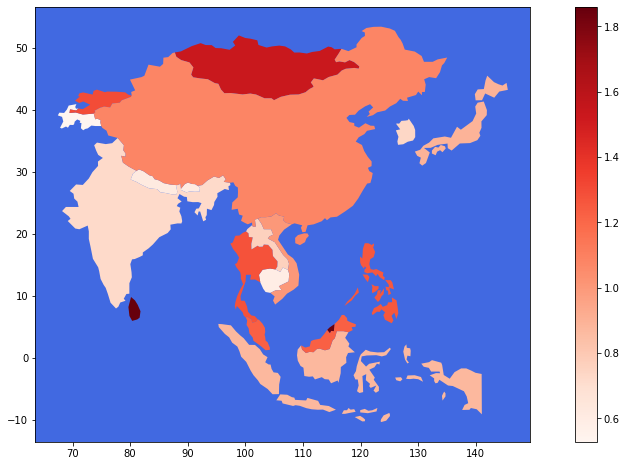

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Gross enrolment ratio, tertiary, gender parity index (GPI) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.ENR.TERT.FM.ZS']

# 2010年のデータのみに絞り込む
data = data[data['Year'] == 2010]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = data.copy() # データのコピー
asia_data = asia_data[data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
asia_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(asia_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)

In [ ]:
asia_data.sort_values('Value', ascending=False)

# 課題
アフリカ諸国を対象として
1. 初等・中等・高等教育の就学率を調べよ。
1. gender parity index (GPI) を調べよ。

いずれも可視化した上で，考察すること。

# 課題(の解答)：アフリカ諸国における教育の現状

<AxesSubplot:title={'center':'tertiary'}>

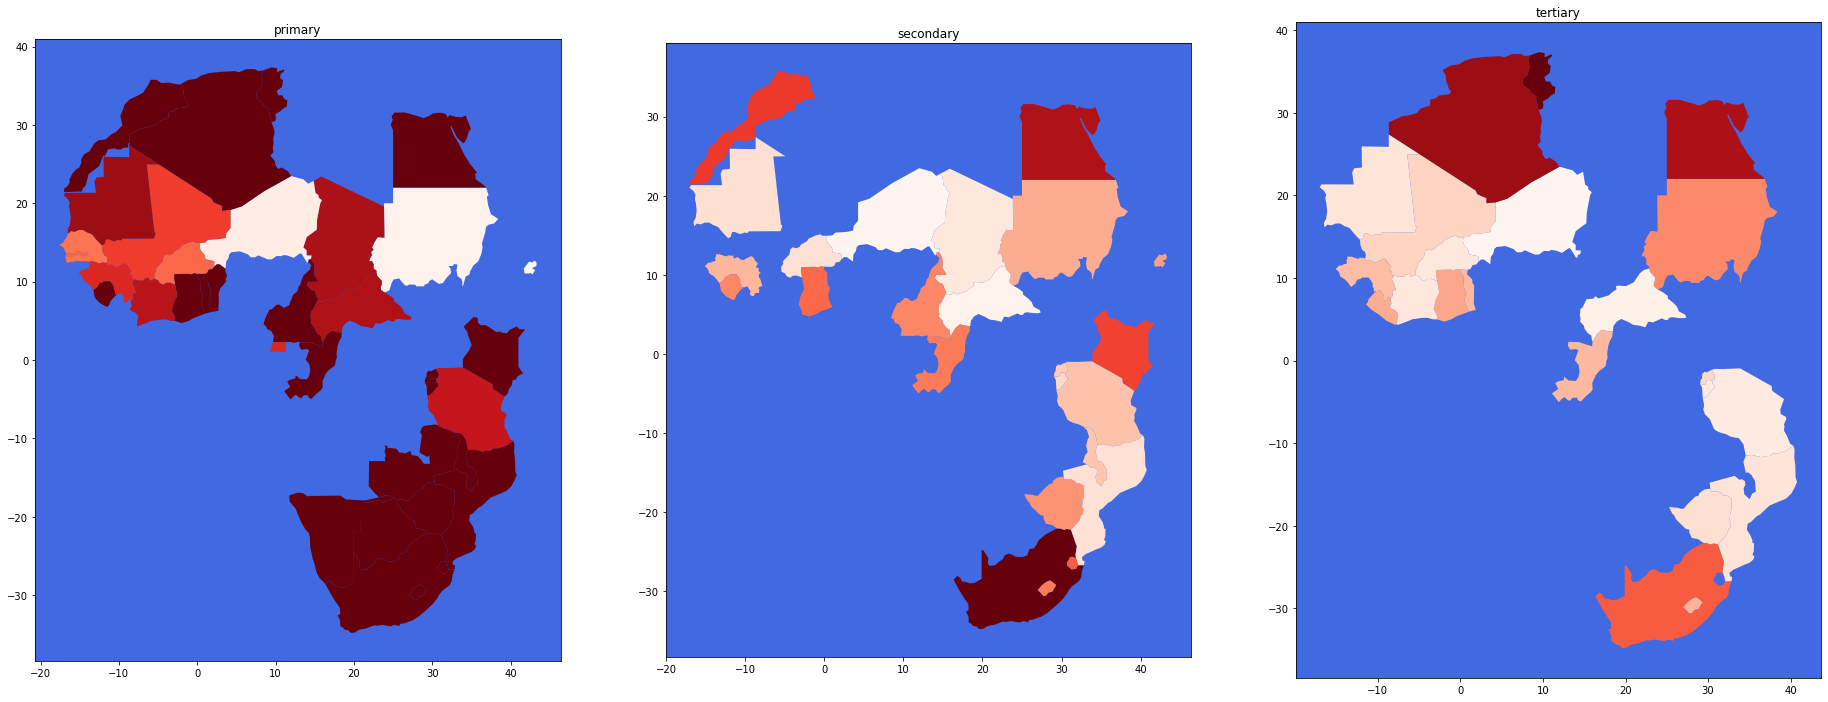

In [ ]:
import pandas as pd

def extract(data, country_iso_a3, year=2012):
    data = data[data['Year'] == year]
    data = data[data['CountryCode'].isin(country_iso_a3)]

    # 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
    extracted_data = data.copy() # データフレームのコピー
    mask = data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
    extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

    # 予め国コードを修正 (アフリカ特有の処理)
    extracted_data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

    # 後のマージのため，列名 CountryCode を iso_a3 へリネーム
    extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

    return extracted_data

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
primary = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']
secondary = indicators[indicators['IndicatorCode'] == 'SE.SEC.ENRR']
tertiary = indicators[indicators['IndicatorCode'] == 'SE.TER.ENRR']

###############################################
# アフリカのみを取り出したい！

# アフリカに分類される国の情報を取得
africa = pd.read_csv('Africa.csv')

# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

# 2012年のデータのみに絞り込む
# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
primary = extract(primary, africa_iso_a3, year=2012)
secondary = extract(secondary, africa_iso_a3, year=2012)
tertiary = extract(tertiary, africa_iso_a3, year=2012)

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 国コードをキーとしてマージする
merged_primary = world.merge(primary, how='inner', on='iso_a3', copy=True)
merged_secondary = world.merge(secondary, how='inner', on='iso_a3', copy=True)
merged_tertiary = world.merge(tertiary, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'royalblue' # 背景色の設定 (複数の図に一斉に設定するパターン)

fig, ax = plt.subplots(1, 3, figsize=(32, 16)) # 1行 3列
ax[0].set_title("primary")
ax[1].set_title("secondary")
ax[2].set_title("tertiary")
merged_primary.plot(ax=ax[0], column='Value', cmap='Reds') #, legend=True)
merged_secondary.plot(ax=ax[1], column='Value', cmap='Reds') #, legend=True)
merged_tertiary.plot(ax=ax[2], column='Value', cmap='Reds') #, legend=True)

# ここから下は試行錯誤中！！

## SE.PRM.ENRR Gross enrolment ratio, primary, both sexes (%)

/home/muto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

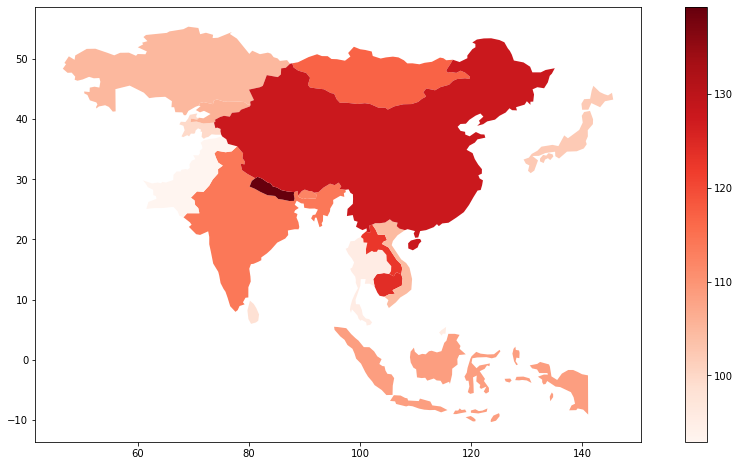

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = data[data['CountryCode'].isin(asia_iso_a3)]

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
asia_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(asia_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
# ax.set_title("Access to electricity (% of population)")
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる


## 提供される指標
500種超の指標が含まれる。

国名(CountryName / CountryCode)×指標(IndicatorName / IndicatorCode) ×年度(1996〜2014)に対して「指標の値」が示されている。

- 対象となる国（地域）数：247カ国
- 指標：511種類
- 年度：指標によって収集された件数が異なる

詳細は Excel ファイル "WDI_code_name.xlsx" を参照


## World Development Indicators のデータを全て読み込む

In [ ]:
import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

### データの中身を確認

In [ ]:
indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


なんと！ Indicators.csv には 565万件ものデータが格納されている！

In [ ]:
len(indicators)

5656458

## Access to electricity (% of population) を見てみよう
各国にて電気を利用可能な国民が人口の何％を占めるかを集計した結果である。

- IndicatorName : Access to electricity (% of population)
- IndicatorCode : EG.ELC.ACCS.ZS

In [ ]:
# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'EG.ELC.ACCS.ZS']

In [ ]:
data['Year'].unique()

array([1990, 2000, 2010, 2012])

'Year' 値を確認すると，1990年，2000年，2010年，2012年のデータが格納されている。

そこで 2012年のデータに絞って調べていこう。

In [ ]:
# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

In [ ]:
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5202284,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,86.270751
5202795,Caribbean small states,CSS,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,93.456157
5203260,Central Europe and the Baltics,CEB,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,100.000000
5203847,East Asia & Pacific (all income levels),EAS,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,96.118489
5204419,East Asia & Pacific (developing only),EAP,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,95.713725


In [ ]:
len(data)

245

データ件数は 245件。ただし，この中には南極大陸の値も含まれるなど，若干，無駄がある。

### アフリカのみを取り出す
Wikipedia 上の国名コードの一覧 ( https://ja.wikipedia.org/wiki/ISO_3166-1 )から
アフリカ大陸に含まれる国名・国コードを抽出した。

その結果をファイル Africa.csv に格納した。

In [ ]:
# アフリカ大陸に含まれる国の情報を取得
africa = pd.read_csv('Africa.csv')

In [ ]:
africa.head()

,国・地域名,ISO 3166-1における英語名,numeric,alpha-3,alpha-2,場所,各行政区分
0,ガーナ,Ghana,288,GHA,GH,西アフリカ,ISO 3166-2:GH
1,カーボベルデ,Cape Verde,132,CPV,CV,西アフリカ,ISO 3166-2:CV
2,ガンビア,Gambia,270,GMB,GM,西アフリカ,ISO 3166-2:GM
3,ギニア,Guinea,324,GIN,GN,西アフリカ,ISO 3166-2:GN
4,ギニアビサウ,Guinea-Bissau,624,GNB,GW,西アフリカ,ISO 3166-2:GW


In [ ]:
# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

In [ ]:
africa_iso_a3.head()

0    GHA
1    CPV
2    GMB
3    GIN
4    GNB
Name: alpha-3, dtype: object

In [ ]:
# CountryCode が「アフリカ諸国の国コードのリスト」に含まれるデータのみ取り出す
africa_data = data[data['CountryCode'].isin(africa_iso_a3)]

In [ ]:
africa_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5225509,Algeria,DZA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,100.00
5226618,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,37.00
5237325,Benin,BEN,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,38.40
5241530,Botswana,BWA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,53.24
5244986,Burkina Faso,BFA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,13.10


In [ ]:
len(africa_data)

50

## geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

#### geopandas に含まれるデータセットを読み込む

In [ ]:
import geopandas
import matplotlib.pyplot as plt

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

In [ ]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


データフレーム world のうち "iso_a3" が国コードを表す。

#### アフリカのデータを再確認

In [ ]:
africa_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5225509,Algeria,DZA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,100.00
5226618,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,37.00
5237325,Benin,BEN,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,38.40
5241530,Botswana,BWA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,53.24
5244986,Burkina Faso,BFA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,13.10


#### ２種類のデータ (world と africa_data) のマージ

In [ ]:
# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
africa_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

/home/muto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
africa_data.head()

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5225509,Algeria,DZA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,100.00
5226618,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,37.00
5237325,Benin,BEN,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,38.40
5241530,Botswana,BWA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,53.24
5244986,Burkina Faso,BFA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,13.10


In [ ]:
# 国コードをキーとしてマージする
wv = world.merge(africa_data, how='inner', on='iso_a3', copy=True)

In [ ]:
wv.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,CountryName,IndicatorName,IndicatorCode,Year,Value
0,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,15.30000
1,7531386,Africa,Somalia,SOM,4719.0,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829...",Somalia,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,32.70795
2,47615739,Africa,Kenya,KEN,152700.0,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712...",Kenya,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,23.00000
3,37345935,Africa,Sudan,SDN,176300.0,"POLYGON ((24.56737 8.22919, 23.80581 8.66632, ...",Sudan,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,32.56256
4,12075985,Africa,Chad,TCD,30590.0,"POLYGON ((23.83766 19.58047, 23.88689 15.61084...",Chad,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,6.40000


<AxesSubplot:>

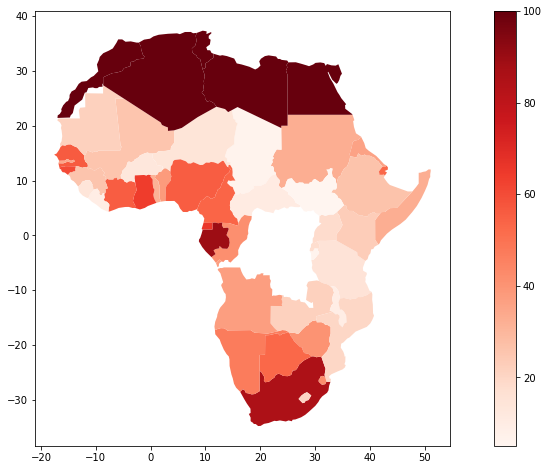

In [ ]:
import matplotlib.pyplot as plt
wv.plot(column='Value', cmap='Reds', legend=True, figsize=(16, 8))

# (参考) Colormap として Paired を用いると，値のない領域が明確になる
# wv.plot(column='Value', cmap='Paired', legend=~True, figsize=(16, 8))


## 真ん中（コンゴ民主共和国）と左上（西サハラっぽい？）の値がない！

参考：
- 左上：西サハラは data の中にない。（国境が未確定だから？ Google maps と形が異なるし・・・）

### 原因を調査してみる
geopandas のデータセット(データフレーム) world ／ World Development Indicators のデータセットに含まれる
"Congo" という国名を調べてみる。

In [ ]:
world[world['name'].str.contains('Congo')]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
67,4954674,Africa,Congo,COG,30270.0,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ..."


In [ ]:
data[data['CountryName'].str.contains('Congo')]

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5255334,"Congo, Dem. Rep.",ZAR,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,16.4
5256220,"Congo, Rep.",COG,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,41.6


コンゴ民主共和国の国コードは
- world の中では 'COD'
- data の中では 'ZAR'
- (参考) Africa.csv では 'COD'

ということは・・・

**大元の africa_data を作る前に 'ZAR' → 'COD' へ変換する必要あり！**

### (参考) サハラについては相当に表記がふらついているようだ

In [ ]:
world[world['name'].str.contains('Sahara')]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


In [ ]:
data[data['CountryName'].str.contains('Sahara')]

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5220874,Sub-Saharan Africa (all income levels),SSF,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,35.306103
5221456,Sub-Saharan Africa (developing only),SSA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,35.274149


## データの改善
コンゴ民主共和国の国コードを予め変換する！

**africa_data を作る前に 'ZAR' → 'COD' へ変換する。**

In [ ]:
# 予め国コードを修正 ・・・ここがポイント！
data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

# CountryCode が「アフリカ諸国の国コードのリスト」に含まれるデータのみ取り出す
africa_data = data[data['CountryCode'].isin(africa_iso_a3)]

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
africa_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(africa_data, how='inner', on='iso_a3', copy=True)

/home/muto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


改めて描画する

<AxesSubplot:>

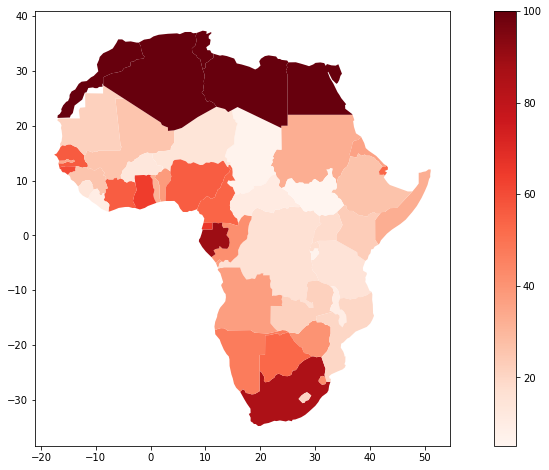

In [ ]:
import matplotlib.pyplot as plt
wv.plot(column='Value', cmap='Reds', legend=True, figsize=(16, 8))

(メモ) 真ん中：南スーダン (South Sudan) は値が約 5% と小さいため，ほぼ白に見える

### コメント
- 北アフリカは地中海を介してヨーロッパと交易が多いのか，電気の整備状況が優れている。
- 南東部は大西洋と接しており，港を介して国が発展しているようだ。
- 中央アフリカの国々の電気の整備率は極めて低い

## 以上のコードをまとめると・・・

/home/muto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:title={'center':'Access to electricity (% of population)'}>

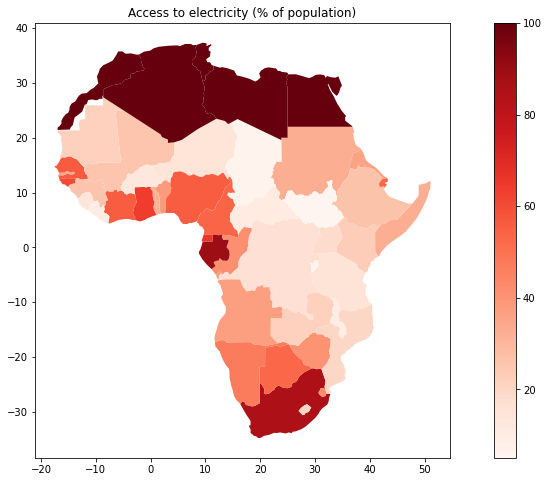

In [ ]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'EG.ELC.ACCS.ZS']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アフリカのみを取り出したい！

# アフリカ大陸に含まれる国の情報を取得
africa = pd.read_csv('Africa.csv')

# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

# CountryCode が「アフリカ諸国の国コードのリスト」に含まれるデータのみ取り出す
africa_data = data[data['CountryCode'].isin(africa_iso_a3)]

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
africa_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(africa_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_title("Access to electricity (% of population)")
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる


# 課題
以下の２つの指標をアフリカ大陸に割り当て可視化せよ。
- "Improved water source (% of rural population with access)" (コードは "SH.H2O.SAFE.ZS")
- "Improved sanitation facilities (% of urban population with access)" (コードは "SH.STA.ACSN")

さらに，得られた結果について考察せよ。

# folium を使ってみよう
Leaflet を使用しているため，Google Colab で動かない可能性あり！

In [ ]:
import folium
africa_map = folium.Map(location=[0.311106, 23.969148], zoom_start=3)
africa_map

In [ ]:
# https://techray.hatenablog.com/entry/2019/12/16/200248

# https://github.com/python-visualization/folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo = f'{url}/world-countries.json'

africa_map.choropleth(geo_data=world_geo,
                      data=africa_data, columns=['CountryName', 'Value'],
                      # data=africa_data, columns=['iso_a3', 'Value'],
                      key_on='properties.name',
                     fill_color='PuBu', fill_opacity=0.7)
africa_map

### コメント
World Development Indicators と folium とで国名表記が異なるためか，一部の国のデータがマップに反映されていない。
→ 要改善！！

# 以下は解答例を示すもの！！！！

## "Improved water source (% of rural population with access)",SH.H2O.SAFE.ZS

In [ ]:
import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SH.H2O.SAFE.ZS']
data['Year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015])

### どうも，リビアはデータを出していないっぽい

/home/muto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

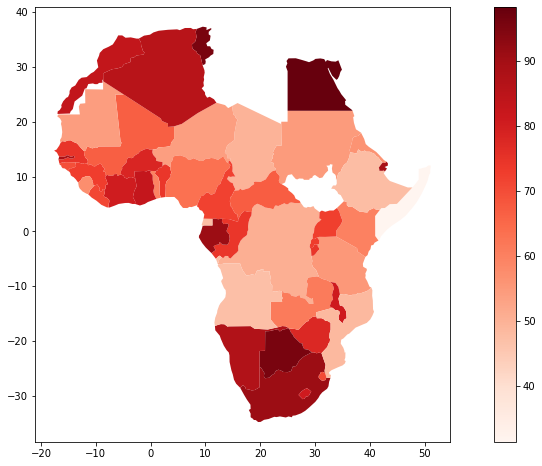

In [ ]:
## "Improved water source, rural (% of rural population with access)",SH.H2O.SAFE.RU.ZS

import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SH.H2O.SAFE.ZS']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2010]

# 予め国コードを修正
data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アフリカのみを取り出したい！

africa = pd.read_csv('Africa.csv')

# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

# CountryCode が「アフリカ諸国の国コードのリスト」に含まれるデータのみ取り出す
africa_data = data[data['CountryCode'].isin(africa_iso_a3)]

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
africa_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(africa_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(ax=ax, column='Value', cmap='Paired', legend=True) # こっちで色を塗ると，値のない領域が明確になる


## "Improved sanitation facilities (% of urban population with access)",SH.STA.ACSN

In [ ]:
import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SH.STA.ACSN']
data['Year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015])

/home/muto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

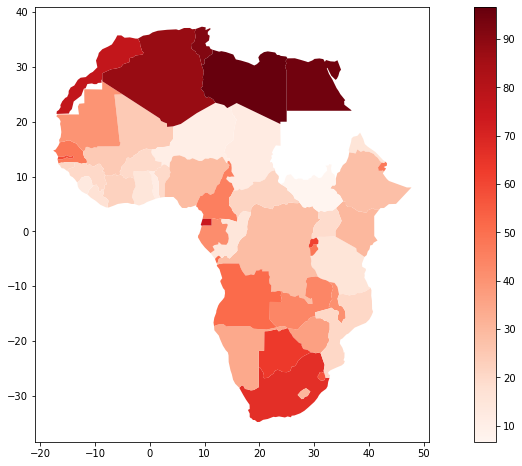

In [ ]:
## "Improved water source, rural (% of rural population with access)",SH.H2O.SAFE.RU.ZS

import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SH.STA.ACSN']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2015]

# 予め国コードを修正
data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アフリカのみを取り出したい！

africa = pd.read_csv('Africa.csv')

# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

# CountryCode が「アフリカ諸国の国コードのリスト」に含まれるデータのみ取り出す
africa_data = data[data['CountryCode'].isin(africa_iso_a3)]

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
africa_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(africa_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(ax=ax, column='Value', cmap='Paired', legend=True) # こっちで色を塗ると，値のない領域が明確になる


## 教育関係へ突っ込む

### SE.PRM.ENRR Gross enrolment ratio, primary, both sexes (%)

In [ ]:
import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']
data['Year'].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014])

/home/muto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

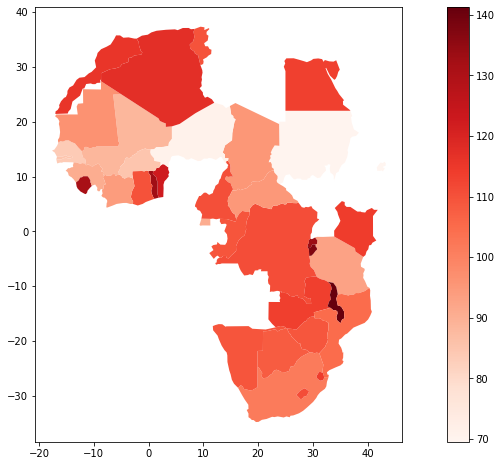

In [ ]:
## SE.PRM.ENRR Gross enrolment ratio, primary, both sexes (%)

import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アフリカのみを取り出したい！

africa = pd.read_csv('Africa.csv')

# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

# CountryCode が「アフリカ諸国の国コードのリスト」に含まれるデータのみ取り出す
africa_data = data[data['CountryCode'].isin(africa_iso_a3)]

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
africa_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(africa_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(ax=ax, column='Value', cmap='Paired', legend=True) # こっちで色を塗ると，値のない領域が明確になる


In [ ]:
import pandas as pd
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.SEC.ENRR']

# 2012年のデータのみに絞り込む
data = data[data['Year'] == 2012]

# 予め国コードを修正
data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アフリカのみを取り出したい！

africa = pd.read_csv('Africa.csv')

# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

# CountryCode が「アフリカ諸国の国コードのリスト」に含まれるデータのみ取り出す
africa_data = data[data['CountryCode'].isin(africa_iso_a3)]

In [ ]:
africa_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5245276,Burkina Faso,BFA,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,2012,25.922911
5246137,Burundi,BDI,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,2012,28.497999
5246969,Cabo Verde,CPV,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,2012,92.738777
5248849,Cameroon,CMR,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,2012,50.377869
5250551,Central African Republic,CAF,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,2012,17.791889


<BarContainer object of 28 artists>

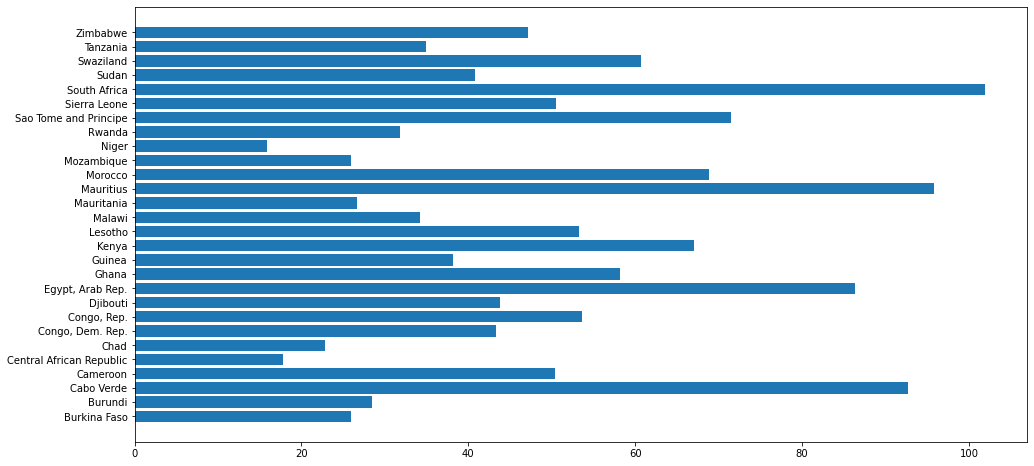

In [ ]:
fig, ax = plt.subplots(1, figsize=(16,8))
ax.barh(africa_data['CountryName'], africa_data['Value'])